## Looking for the best ratio between labeled and unlabeled images in Self-training with Noisy Student

### Authors: Weiwei Zhan(wz2483) & Yu Huang(yh3019)

**This code is to do self-training to get teacher model, "student1", and "student2" models. And then we evaluate them on test data.**
* Data: SVHN dataset 

* Model: EfficientNet

* Ratio of unlabelled:labelled in each model fitting process: **1** & **3**

* Initial Teacher model use 5,000 images

* Only data augmentation for student model

* Epoch Number: 50 epoches for teacher model, 30 epoches for student model at the first iteration, 20 epoches for student model at the second iteration

In [3]:
from __future__ import print_function

import os
import pickle

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from keras.utils import np_utils

from sklearn.model_selection import train_test_split

# from keras.applications.imagenet_utils import decode_predictions

from efficientnet.tfkeras import EfficientNetB0, EfficientNetB7
from efficientnet.tfkeras import center_crop_and_resize, preprocess_input

import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings 
warnings.simplefilter(action='ignore')

In [2]:
!pip install opencv-python
!pip install efficientnet
!pip install imgaug

  Using cached efficientnet-1.1.0-py3-none-any.whl (18 kB)
  Using cached imgaug-0.4.0-py2.py3-none-any.whl (948 kB)
  Using cached opencv_python-4.2.0.32-cp37-cp37m-manylinux1_x86_64.whl (28.2 MB)


In [2]:
keras.__version__, tf.__version__

('2.2.4-tf', '1.13.1')

### Download dataset and load

http://ufldl.stanford.edu/housenumbers/

In [3]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/extra_32x32.mat

In [4]:
from scipy.io import loadmat
train = loadmat('train_32x32.mat')
test  = loadmat('test_32x32.mat')
extra = loadmat('extra_32x32.mat')

### Data preprocessing and split

In [5]:
# set initial labeled data size for teacher model training
num_label = 5000
num_classes = 10

In [6]:
x_train, y_train = train['X'],train['y']
x_test,  y_test  = test['X'], test['y']
x_extra, y_extra = extra['X'],extra['y']

# combine the train file and extra file
x_train = np.concatenate((x_train,x_extra),axis=3)
y_train = np.concatenate((y_train,y_extra),axis=0)

# move the number of samples to the first position
x_train  = np.moveaxis(x_train,-1,0)
x_test1  = np.moveaxis(x_test,-1,0)

# In original dataset, Digit '1' has label 1, '9' has label 9 and '0' has label 10.
# Now we change it to: Digit '1' has label 1, '9' has label 9 and '0' has label 0.
y_train[y_train==10] = 0
y_test[y_test==10] = 0

Y data preprocessing

In [7]:
def preprocessing_y(y_train1):
    # convert class vectors to binary class matrices
    y_train1 = y_train1.reshape(y_train1.shape[0],)

    # one hot encoding
    y_train1 = keras.utils.to_categorical(y_train1, num_classes, dtype='uint8')
    
    return y_train1

In [8]:
y_train = preprocessing_y(y_train)
print('Preprocessing for ALL training Y finished.')
y_test  = preprocessing_y(y_test)
print('Preprocessing for ALL test Y finished.')

Preprocessing for ALL training Y finished.
Preprocessing for ALL test Y finished.


### split data to: 

1) to be used (x_train1, y_train1)
2) not to be used (x_unused1, y_unused1)

In [9]:
# split data to to be used and not to be used by num_label
# only do preprocessing for the data to be used to avoid halted run
x_train1, x_unused1, y_train1, y_unused1 = train_test_split(x_train,y_train, train_size=num_label, random_state=31, shuffle=True)

# y_train1 = preprocessing_y(y_train1)
print('Teacher model training data preprocessing finished.')

# release some memory 
del x_extra, y_extra #wwz

# backup them before validation split so we can combine these images with unlabelled ones later!
x_train1_backup = x_train1.copy()
y_train1_backup = y_train1.copy()

Teacher model training data preprocessing finished.


### split data to:

1) training set (x_train1, y_train1) 
2) validation set (x_valid1, y_valid1)

In [10]:
# split training & validation set
x_train1, x_valid1, y_train1, y_valid1 = train_test_split(x_train1,y_train1, test_size=0.1, random_state=31,shuffle=True)

print('Teacher model validation split finished.')

Teacher model validation split finished.


x_train shape: (4500, 32, 32, 3)
y_train shape: (4500, 10)
4500 train samples
500 validation samples
26032 test samples
[1 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 1] [0 0 1 0 0 0 0 0 0 0]


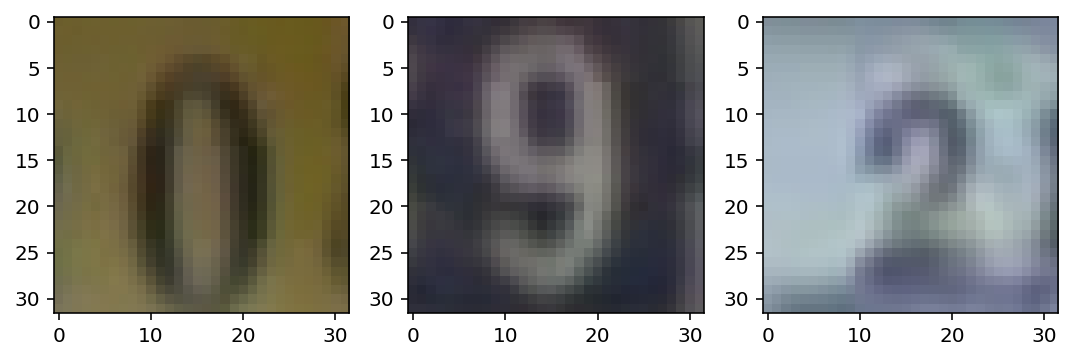

In [11]:
print('x_train shape:', x_train1.shape)
print('y_train shape:', y_train1.shape)
print(x_train1.shape[0], 'train samples')
print(x_valid1.shape[0], 'validation samples')
print(x_test1.shape[0], 'test samples')

# check the first sample in training set & test set
fig,axes = plt.subplots(figsize=(9,4),ncols=3)
axes[0].imshow(x_train1[1])
axes[1].imshow(x_valid1[1])
axes[2].imshow(x_test1[1])
print(y_train1[1],y_valid1[1],y_test[1])

In [12]:
x_train1.dtype

dtype('uint8')

### Data augmentation setup
For teacher & validation - Just Scale! No Augmentation!

For student - Augmentation! To change color, brightness, contrast, crop ...

reference:

https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

https://imgaug.readthedocs.io/en/latest/source/examples_basics.html

In [13]:
### Data augmentation definition function
import imgaug as ia
import imgaug.augmenters as iaa
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second
# image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq = iaa.Sequential([

    iaa.MultiplyBrightness((0.5, 1.5)),
    # Create an augmenter that takes 20x20 sized crops from the center of images.
    sometimes(iaa.KeepSizeByResize(iaa.CenterCropToFixedSize(height=32, width=32),interpolation="nearest")),
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    sometimes(iaa.GaussianBlur(sigma=(0, 0.5))),
    
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.8, 1.5), per_channel=True),
    
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
              
              
    # Apply affine transformations to some of the images
    # - scale/zoom to 80-120% of image height/width (each axis independently)
    # - translate/move by -20 to +20 relative to height/width (per axis)
    # - rotate by -5 to +5 degrees
    # - shear by -8 to +8 degrees
    # - order: use nearest neighbour or bilinear interpolation (fast)
    sometimes(iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
#         translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-5, 5),
        shear=(-8, 8),
        order=[0, 1]))
],random_order=True) # do all of the above augmentations in random order
    
def augment_student(img):
        seq_det = seq.to_deterministic()
        img     = img.astype(np.uint8)
        aug_image = seq_det.augment_image(img)
        aug_image = aug_image.astype(np.float32)
        aug_image = aug_image/255     
        return aug_image

# only do rescale for teacher model
def augment_teacher(img):
        img     = img.astype(np.float32)
        img     = img/255
        return img
    
# only do rescale for validation
def augment_validation(img):
        img     = img.astype(np.float32)
        img     = img/255
        return img

In [14]:
# define the data generators

aug_teacher = ImageDataGenerator(preprocessing_function=augment_teacher)

aug_student = ImageDataGenerator(preprocessing_function=augment_student)
    
aug_validation = ImageDataGenerator(preprocessing_function=augment_validation)

# aug_test = ImageDataGenerator(preprocessing_function=augment_validation) #wwz

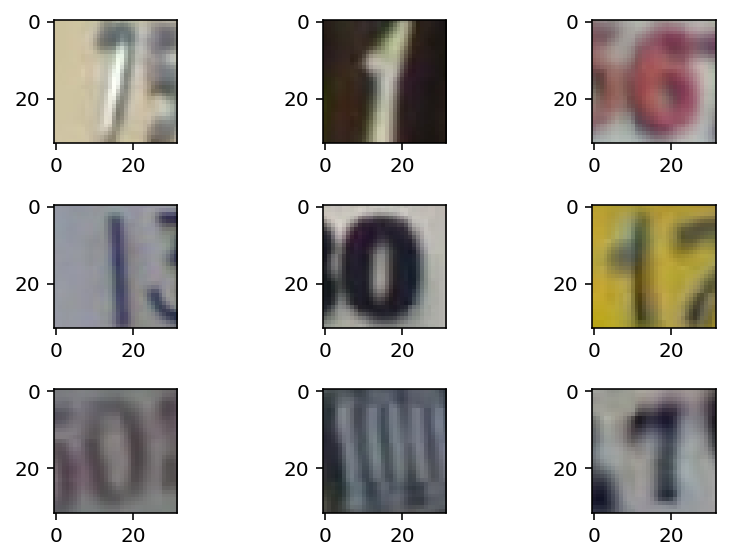

In [15]:
for X_batch, y_batch in aug_teacher.flow(x_train1, y_train1, batch_size=9,seed=3019):
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i])
    plt.tight_layout()
    break

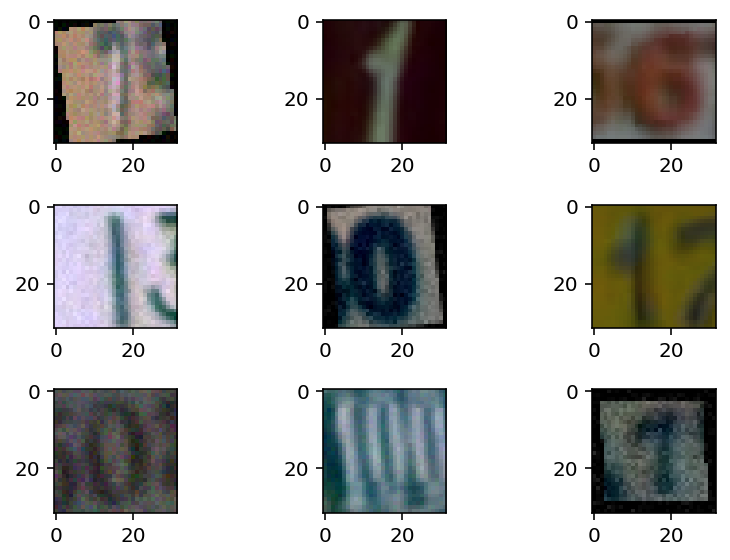

In [16]:
for X_batch, y_batch in aug_student.flow(x_train1, y_train1, batch_size=9,seed=3019):
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i])
    plt.tight_layout()
    break

### Build and train teacher model

In [17]:
# a function to build the model
# only one dense layer between the base model and the prediction layer
def build_model(img_size, base_model_type, drop_rate, intermediate_dense_num):
    # loading pretrained model
    if base_model_type == 'ENB0':
        base_model = EfficientNetB0(weights='imagenet',input_shape=(img_size,img_size,3),include_top=False)
    if base_model_type == 'ENB7':
        base_model = EfficientNetB7(weights='imagenet',input_shape=(img_size,img_size,3),include_top=False)
    
    # check if the pre-trained model is trainable:
    for layers in base_model.layers:
        print(layers.trainable)
        break
        
    x = base_model.output
    x = Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(drop_rate)(x) # once used 0.2 too but not as good as 0.5
    
    if intermediate_dense_num == 3:
        x = Dense(1024, activation="relu")(x)
        x = Dropout(drop_rate)(x) # once used 0.2 too but not as good as 0.5
        x = Dense(128, activation="relu")(x)
        x = Dropout(drop_rate)(x) # once used 0.2 too but not as good as 0.5
            
    predictions = Dense(units = 10, activation="softmax")(x)
    model = Model(inputs = base_model.input, outputs = predictions)
    return model

In [18]:
# set up some model parameters
img_size   = 32
base_model_type = 'ENB0'
drop_rate = 0.5
intermediate_dense_num = 1

batch_size  = 128
epochs = 50
model_name = 'teachermodel_5000i_SVHN_50e_730v_drop05' #'teachermodel_first_SVHN'

In [19]:
# build the model and save the model summary 
model = build_model(img_size, base_model_type, drop_rate, intermediate_dense_num)

filename = './models/'+model_name+'summary.txt'

with open(filename,'w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
True


In [9]:
# Here we use F1-score and categorical_accuracy as evaluation metrics
import keras.backend as K

def f1_m(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [137]:
model.compile(optimizers.RMSprop(lr=0.0001),loss='categorical_crossentropy',metrics=['categorical_accuracy', f1_m])

H = model.fit_generator(aug_teacher.flow(x_train1, y_train1, batch_size=batch_size),
                        epochs           = epochs,
                        steps_per_epoch  = len(x_train1) // batch_size,
                        validation_data  = aug_validation.flow(x_valid1, y_valid1, batch_size=batch_size),
                        validation_steps = len(x_valid1)// batch_size,
                        verbose=0) # only get output metrics for validation data  

4/4 [==============================] - 1s 284ms/step - loss: 1.3680 - categorical_accuracy: 0.7300 - f1_m: 0.7176


### Save the model & training process

In [21]:
def plot_training(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    f1 = history.history['f1_m']
    val_f1 = history.history['val_f1_m']
    epochs = range(len(acc))

    fig, axes = plt.subplots(figsize=(12,4),ncols=3)

    axes[0].plot(epochs, acc, 'b',label='Train')
    axes[0].plot(epochs, val_acc, 'r',label='Validation')
    axes[0].set_title('Training and validation accuracy')
    axes[0].legend()

    axes[1].plot(epochs, loss, 'b')
    axes[1].plot(epochs, val_loss, 'r')
    axes[1].set_title('Training and validation loss')

    axes[2].plot(epochs, f1, 'b')
    axes[2].plot(epochs, val_f1, 'r')
    axes[2].set_title('Training and validation F1 score')


def save_and_plot(model, model_name, H):
    # save the final model
    model.save("./models/"+model_name+".hdf5")
    
    plot_training(H)
    plt.tight_layout()
    plt.rcParams['savefig.dpi'] = 220
    plt.savefig('./Figures/'+model_name+'.png')
    
    # save the evolultion process of the metrics during training
    pickle_name = './models/'+model_name+'.pckl'
    os.makedirs(os.path.dirname(pickle_name), exist_ok=True)
    f = open(pickle_name, 'wb')
    pickle.dump(H.history, f)
    f.close()

In [ ]:
save_and_plot(model, model_name, H)

### Prepare data for student1 - generate psuedo labels and combine last step train data and new unlabeled data 

In [22]:
# -------- YOU NEED TO CHANGE ---------
R = 3
num_unlabel = num_label * R

# select unlabeled data from unused data(x_unused,y_unused)
x_unlabel1, x_unused2, y_unlabel1, y_unused2 = train_test_split(
    x_unused1,y_unused1, train_size=num_unlabel, random_state=31,shuffle=True)

y_unlabel1_backup = y_unlabel1.copy()

In [23]:
del x_unused1,y_unused1

In [24]:
x_unlabel1.shape,y_unlabel1.shape

((15000, 32, 32, 3), (15000, 10))

In [25]:
# Restore teacher model and predict and preprocessing y
from tensorflow.keras.models import load_model

# model_name
model_teacher = 'teachermodel_5000i_SVHN_50e_744v_drop05' 

def pesodu_label_generator(model_teacher, x_unlabel1):
    teacher_model = load_model("./models/"+model_teacher+".hdf5", custom_objects={"f1_m": f1_m})
    
    # preprocess unlabeled x 
    x_unlabel1 = x_unlabel1.astype('float32')
    x_unlabel1 = x_unlabel1/255.
    
    # Predict psuedo labels
    y_proba1 = teacher_model.predict(x_unlabel1)
    # y_proba1 = teacher_model.predict(aug_test.flow(x_unlabel1)) # steps = len(x_unlabel1)
    y_unlabel1 = np.argmax(y_proba1, axis=1)
    y_unlabel1 = preprocessing_y(y_unlabel1)
    
    return teacher_model, y_unlabel1

teacher_model, y_unlabel1 = pesodu_label_generator(model_teacher, x_unlabel1)

print('Pesudo label prediction finished.')

Instructions for updating:
Use tf.cast instead.
Pesudo label prediction finished.


#### Confusion matrix - 0 and 9 are the hardest numbers to predict

In [26]:
# compute and plot confusion matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# fig, axes = plt.subplots(figsize=(8,4),ncols=2)
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues,save_path=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    fig, axes = plt.subplots(figsize=(12,6),ncols=2)
    
    im = axes[0].imshow(cm, interpolation='nearest', cmap=cmap)
    axes[0].set_title('Confusion matrix without normalization')
    fig.colorbar(im,ax=axes[0],shrink=0.75)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[0].text(j, i, cm[i, j],horizontalalignment="center", fontsize=8,
                         color="white" if cm[i, j] > thresh else "black")

    # normalized
    cm_n = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_n = np.around(cm_n,decimals=2)

    im_n = axes[1].imshow(cm_n, interpolation='nearest', cmap=cmap)
    axes[1].set_title('Normalized confusion matrix')
    fig.colorbar(im_n,ax=axes[1],shrink=0.75)

    thresh = cm_n.max() / 2.
    for i in range(cm_n.shape[0]):
        for j in range(cm_n.shape[1]):
            axes[1].text(j, i, cm_n[i, j],horizontalalignment="center", fontsize=8,
                         color="white" if cm_n[i, j] > thresh else "black")

    tick_marks = np.arange(len(classes))
    for ax in axes:
        ax.set_xticks(tick_marks)
        ax.set_xticklabels(classes, rotation=45)
        ax.set_yticks(tick_marks)
        ax.set_yticklabels(classes, rotation=45)
        ax.set_ylabel('True label')
        ax.set_xlabel('Predicted label')

    plt.tight_layout()
    
    if save_path is not None:
        plt.rcParams['savefig.dpi'] = 220
        plt.savefig('./Figures/confusion_matrix_'+save_path+'.png')

    
    print('Confusion matrix, without normalization')
    # print(cm)
    print("Normalized confusion matrix")
    # print(cm_n)
    plt.show()

Confusion matrix, without normalization
Normalized confusion matrix


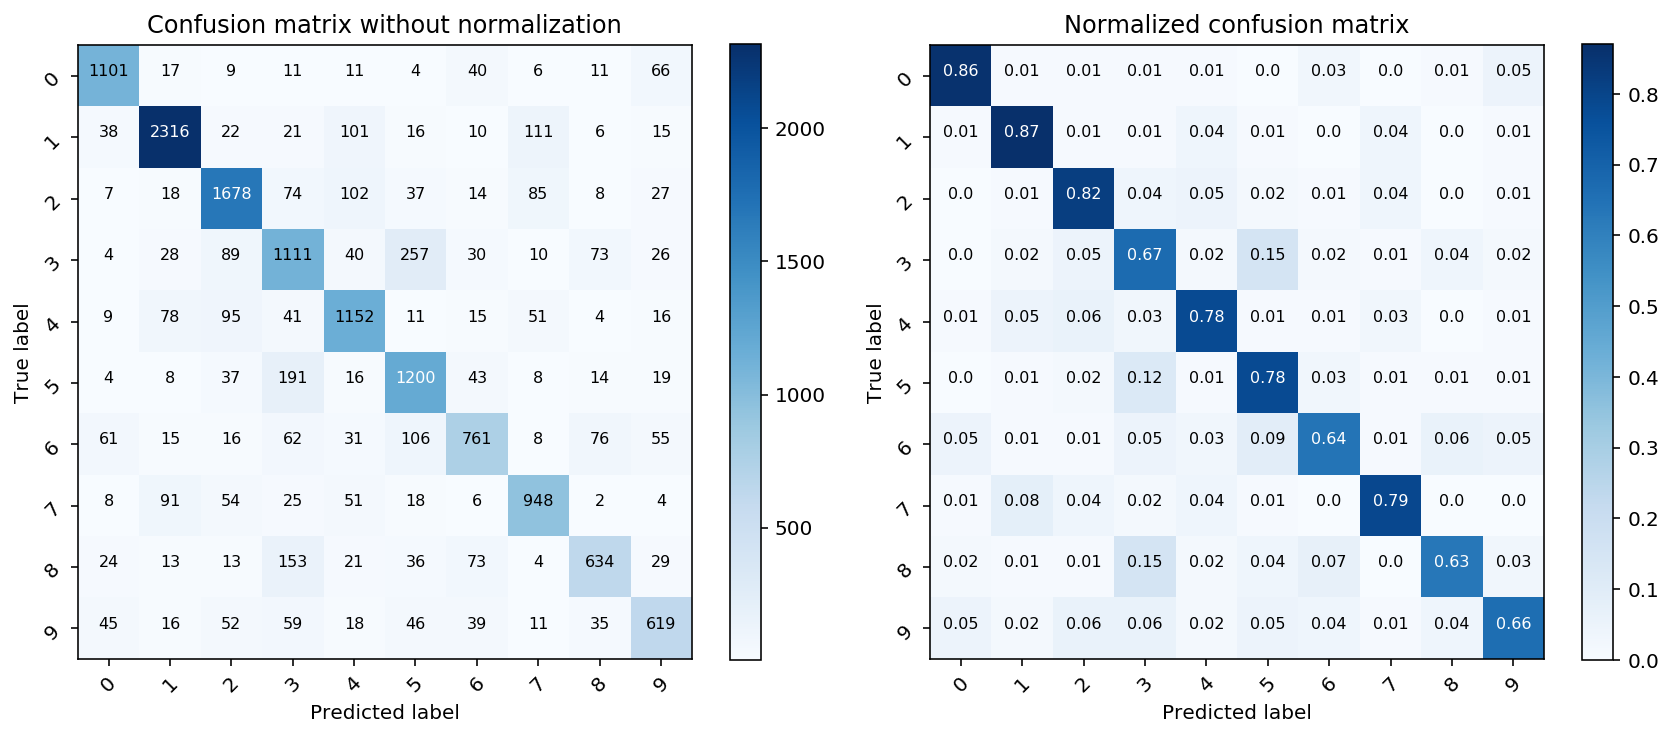

In [29]:
# Compute confusion matrix
class_labels=['0','1','2','3','4','5','6','7','8','9']

cnf_matrix = confusion_matrix(y_unlabel1_backup.argmax(axis=-1), y_unlabel1.argmax(axis=-1)) #wwz
plot_confusion_matrix(cnf_matrix, classes=class_labels, 
                      cmap=plt.cm.Blues,
                      save_path=model_name)

In [30]:
# Combine label & unlabel1
# NOTE because x_train1 is actually not augmented so we can combine together
# In the next round, we cannot combine the data without augmentation and with augmentation! So we need a back up!
x_train2 = np.concatenate((x_train1_backup,x_unlabel1),axis=0)
y_train2 = np.concatenate((y_train1_backup,y_unlabel1),axis=0)

# del x_train1, x_valid1, y_train1, y_valid1
# del x_unlabel1, y_unlabel1, x_train1_backup, y_train1_backup

x_train2_backup = x_train2.copy()
y_train2_backup = y_train2.copy()

print('New unlabled data and training+validation from teacher model finished.')

New unlabled data and training+validation from teacher model finished.


In [31]:
np.shape(x_train2), np.shape(y_train2)

((20000, 32, 32, 3), (20000, 10))

In [32]:
# split training & validation set
x_train2, x_valid2, y_train2, y_valid2 = train_test_split(x_train2,y_train2, test_size=0.1, random_state=31,shuffle=True)
print('Student1 training validation split finished.')

Student1 training validation split finished.


### Build and fit Student1

In [33]:
batch_size  = 128
epochs      = 30

model_name = 'studentmodel1_R3_5000i_SVHN_30e_drop05_iter1' # 'teachermodel_first_SVHN' #wwz
model      = build_model(img_size, 'ENB0', drop_rate, 1)

model.compile(optimizers.RMSprop(lr=0.0001),loss='categorical_crossentropy',metrics=['categorical_accuracy', f1_m])

True


In [35]:
#Save the model after every epoch.
from tensorflow.keras.callbacks import ModelCheckpoint,Callback

maxacc_filepath = './models/'+ model_name +'_30epoch_avg-{epoch:02d}-{val_categorical_accuracy:.2f}_{val_f1_m:.2f}.hdf5' 
checkpoint1 = ModelCheckpoint(filepath=maxacc_filepath, monitor='val_categorical_accuracy',
                              verbose=1, save_best_only=True, mode="max", period=10) #wwz
callbacks_list = [checkpoint1]

In [36]:
H = model.fit_generator(aug_student.flow(x_train2, y_train2, batch_size=batch_size), #wwz
                        epochs           = epochs,
                        steps_per_epoch  = len(x_train2) // batch_size,
                        validation_data  = aug_validation.flow(x_valid2, y_valid2, batch_size=batch_size),
                        validation_steps = len(x_valid2)// batch_size,
                        callbacks=callbacks_list,
                        verbose=0) # only get output metrics for validation data  

16/16 [==============================] - 5s 336ms/step - loss: 0.6140 - categorical_accuracy: 0.8010 - f1_m: 0.7670

Epoch 00010: val_categorical_accuracy improved from -inf to 0.80100, saving model to ./models/studentmodel1_R3_5000i_SVHN_30e_drop05_iter1_30epoch_avg-10-0.80_0.77.hdf5
16/16 [==============================] - 6s 355ms/step - loss: 0.5686 - categorical_accuracy: 0.8105 - f1_m: 0.7904

Epoch 00020: val_categorical_accuracy improved from 0.80100 to 0.81050, saving model to ./models/studentmodel1_R3_5000i_SVHN_30e_drop05_iter1_30epoch_avg-20-0.81_0.79.hdf5
16/16 [==============================] - 5s 336ms/step - loss: 0.5893 - categorical_accuracy: 0.8180 - f1_m: 0.7869

Epoch 00030: val_categorical_accuracy improved from 0.81050 to 0.81800, saving model to ./models/studentmodel1_R3_5000i_SVHN_30e_drop05_iter1_30epoch_avg-30-0.82_0.79.hdf5


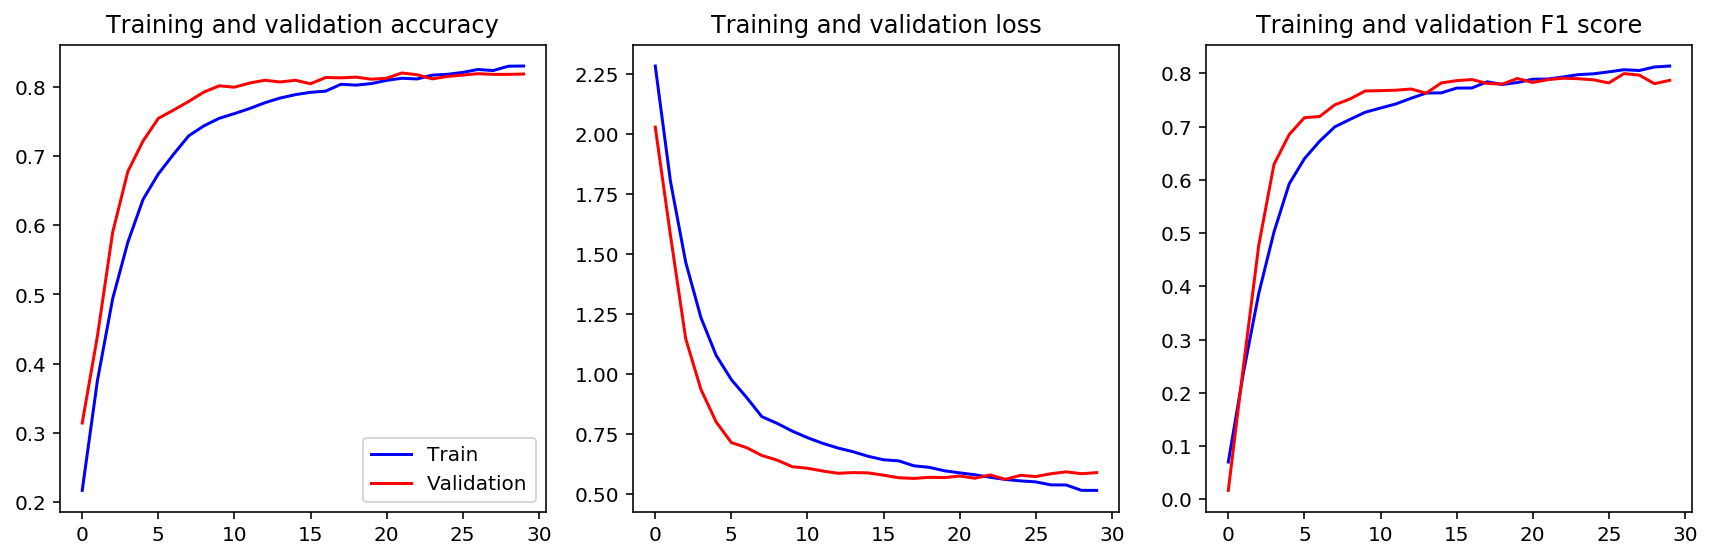

In [37]:
save_and_plot(model, model_name, H)

### Prepare data for student2 - generate psuedo labels and combine last step train data and new unlabeled data 

In [38]:
num_label

5000

In [39]:
# -------- YOU NEED TO CHANGE ---------
num_label = num_label*(1+R) # 10,000 if R=1, 20,000 if R=3

R = 3
num_unlabel = num_label * R # 10,000 if R=1, 60,000 if R=3

# select unlabeled data from unused data(x_unused,y_unused)
x_unlabel2, x_unused3, y_unlabel2, y_unused3 = train_test_split(
    x_unused2,y_unused2, train_size=num_unlabel, random_state=31,shuffle=True)

y_unlabel2_backup = y_unlabel2.copy()
# del x_unused2,y_unused2

In [42]:
x_unlabel2.shape, y_unlabel2.shape

((60000, 32, 32, 3), (60000, 10))

In [43]:
# Restore teacher model(student model last step) and predict and preprocessing y

# model_name
model_teacher = 'studentmodel1_R3_5000i_SVHN_30e_drop05_iter1'#'studentmodel1_5000i_SVHN_50e_744v_drop05_iter1' #wwz

teacher_model, y_unlabel2 = pesodu_label_generator(model_teacher, x_unlabel2)

print('Pesudo label prediction finished.')

Pesudo label prediction finished.


Confusion matrix, without normalization
Normalized confusion matrix


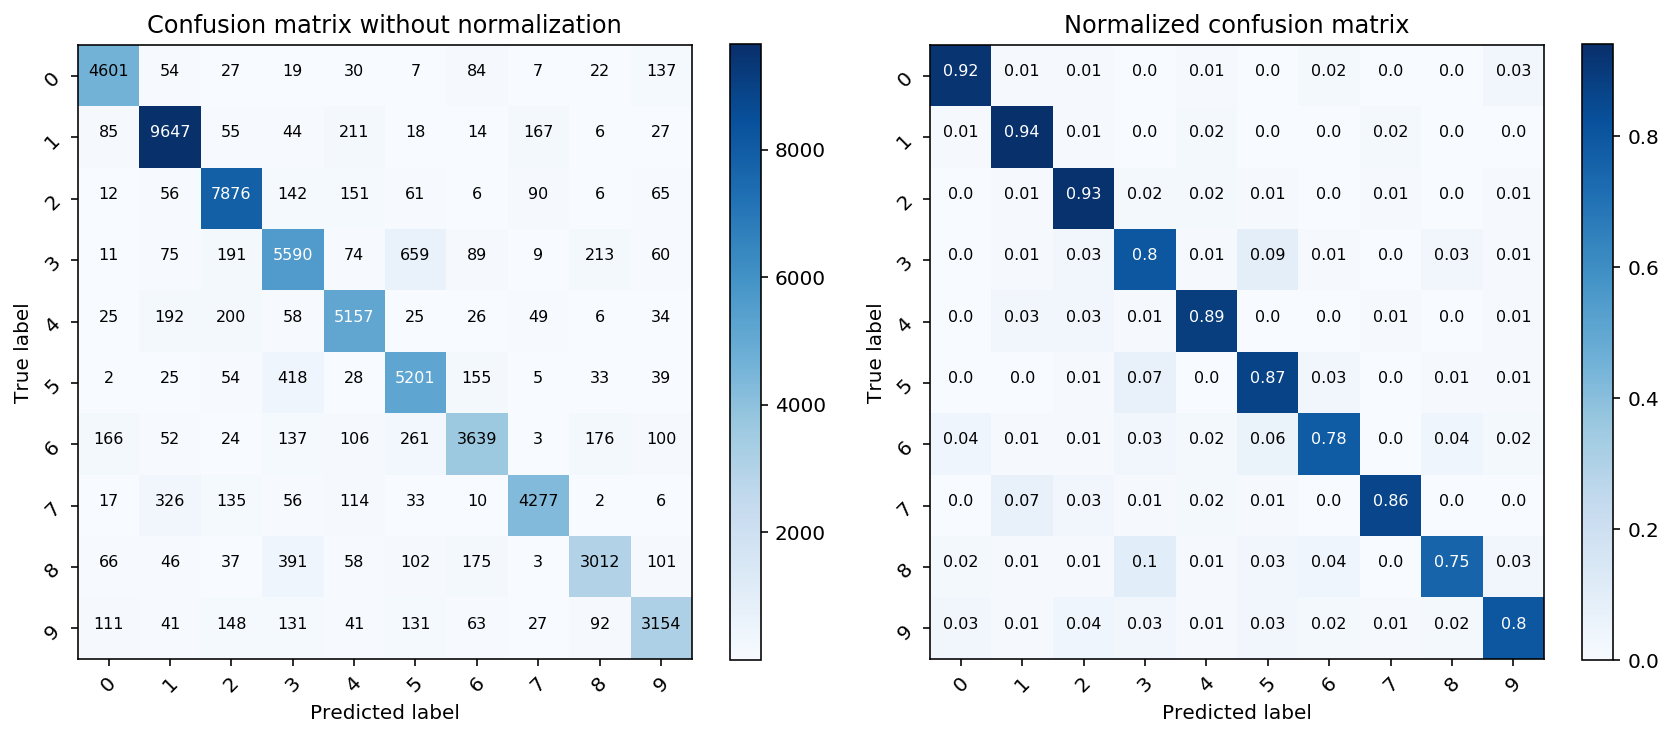

In [44]:
cnf_matrix = confusion_matrix(y_unlabel2_backup.argmax(axis=-1), y_unlabel2.argmax(axis=-1)) #wwz
plot_confusion_matrix(cnf_matrix, classes=class_labels, 
                      cmap=plt.cm.Blues,
                      save_path=model_name)

In [45]:
# Combine label & unlabel2
x_train3 = np.concatenate((x_train2_backup,x_unlabel2),axis=0)
y_train3 = np.concatenate((y_train2_backup,y_unlabel2),axis=0)

del x_train2, x_valid2, y_train2, y_valid2
# del x_unlabel2, y_unlabel2, x_train2_backup, y_train2_backup

print('New unlabled data and training+validation from student1 model finished.')

New unlabled data and training+validation from student1 model finished.


In [46]:
np.shape(x_train3), np.shape(y_train3)

((80000, 32, 32, 3), (80000, 10))

In [47]:
# split training & validation set
x_train3, x_valid3, y_train3, y_valid3 = train_test_split(x_train3,y_train3, test_size=0.1, random_state=31,shuffle=True)

print('Student2 training validation split finished.')

Student2 training validation split finished.


### Build and fit Student2

epoch number: 20

In [48]:
batch_size  = 128
epochs      = 20

model_name  = 'studentmodel1_R3_5000i_SVHN_30e_drop05_iter2' # 'teachermodel_first_SVHN' #wwz
model       = build_model(img_size, 'ENB0', drop_rate, 1)

model.compile(optimizers.RMSprop(lr=0.0001),loss='categorical_crossentropy',metrics=['categorical_accuracy', f1_m])

True


In [51]:
#Save the model after every epoch.
from tensorflow.keras.callbacks import ModelCheckpoint,Callback

maxacc_filepath = './models/'+ model_name +'_20epoch_avg-{epoch:02d}-{val_categorical_accuracy:.2f}_{val_f1_m:.2f}.hdf5' 
checkpoint1 = ModelCheckpoint(filepath=maxacc_filepath, monitor='val_categorical_accuracy',
                              verbose=1, save_best_only=True, mode="max", period=5)  #wwz
callbacks_list = [checkpoint1]

In [52]:
H_student2 = model.fit_generator(aug_student.flow(x_train3, y_train3, batch_size=batch_size), #wwz
                        epochs           = epochs,
                        steps_per_epoch  = len(x_train3) // batch_size,
                        validation_data  = aug_validation.flow(x_valid3, y_valid3, batch_size=batch_size),
                        validation_steps = len(x_valid3)// batch_size,
                        callbacks=callbacks_list,
                        verbose=0) # only get output metrics for validation data  

63/63 [==============================] - 22s 354ms/step - loss: 0.3210 - categorical_accuracy: 0.9020 - f1_m: 0.8884

Epoch 00005: val_categorical_accuracy improved from -inf to 0.90200, saving model to ./models/studentmodel1_R3_5000i_SVHN_30e_drop05_iter2_20epoch_avg-05-0.90_0.89.hdf5
63/63 [==============================] - 22s 356ms/step - loss: 0.3105 - categorical_accuracy: 0.9024 - f1_m: 0.8944

Epoch 00010: val_categorical_accuracy improved from 0.90200 to 0.90237, saving model to ./models/studentmodel1_R3_5000i_SVHN_30e_drop05_iter2_20epoch_avg-10-0.90_0.89.hdf5
63/63 [==============================] - 24s 374ms/step - loss: 0.3038 - categorical_accuracy: 0.9029 - f1_m: 0.8871

Epoch 00015: val_categorical_accuracy improved from 0.90237 to 0.90288, saving model to ./models/studentmodel1_R3_5000i_SVHN_30e_drop05_iter2_20epoch_avg-15-0.90_0.89.hdf5
63/63 [==============================] - 21s 336ms/step - loss: 0.3185 - categorical_accuracy: 0.9018 - f1_m: 0.8913

Epoch 00020: va

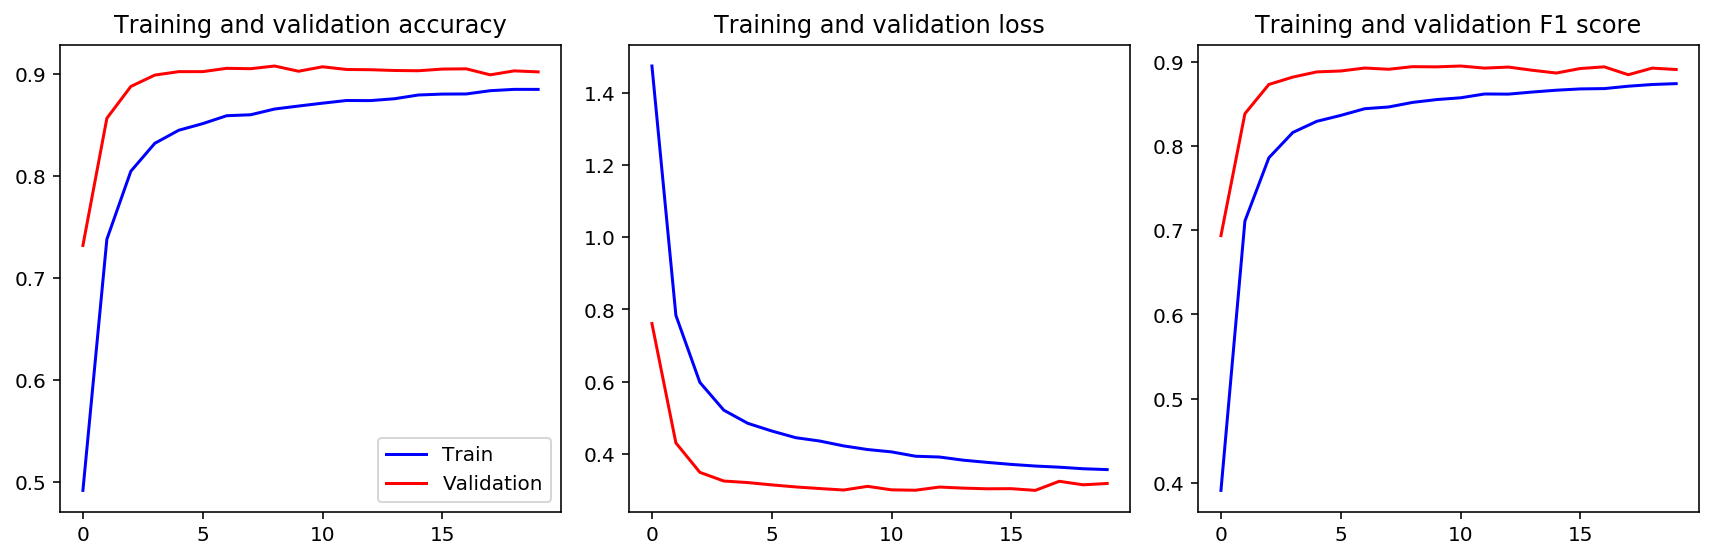

In [53]:
save_and_plot(model, model_name, H_student2) #wwz

### Final evalution of the three models on test data

In [54]:
# Do not use all test data, 2000 test images will be enough
x_test, x_test_unused, y_test, y_test_unused = train_test_split(x_test1, y_test, train_size=2000, random_state=31, shuffle=True) #wwz

In [55]:
model1_name = 'teachermodel_5000i_SVHN_50e_744v_drop05' 
model2_name = 'studentmodel1_R3_5000i_SVHN_30e_drop05_iter1' #wwz
model3_name = 'studentmodel1_R3_5000i_SVHN_30e_drop05_iter2' #wwz

model1, y_pred1 = pesodu_label_generator(model1_name, x_test)
model2, y_pred2 = pesodu_label_generator(model2_name, x_test)
model3, y_pred3 = pesodu_label_generator(model3_name, x_test)

print('Test data prediction finished.')

Test data prediction finished.


#### Visualize the predictions of three models

In [56]:
y_pred1.shape

(2000, 10)

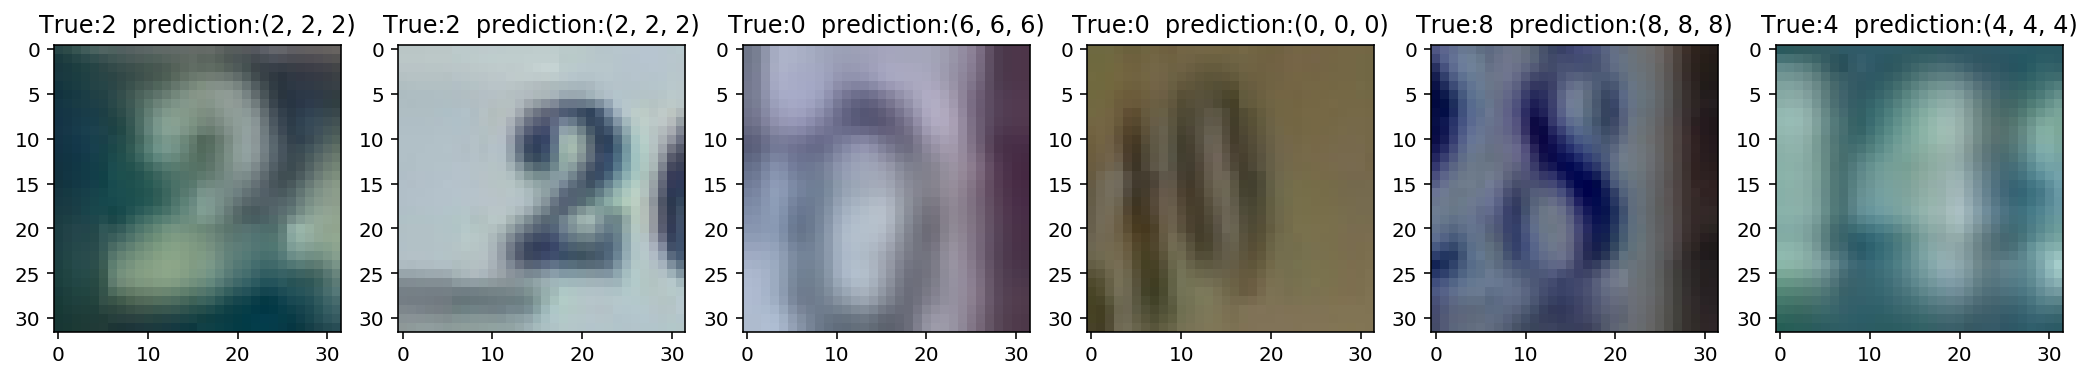

In [57]:
from random import seed
from random import randint

# seed random number generator
seed(31)

fig, axes = plt.subplots(figsize=(18,3),ncols=6)

# generate 6 integers
for i in range(6):
    value = randint(0,x_test.shape[0])
    axes[i].imshow(x_test[value])
    
    pre_label1 = y_pred1.argmax(axis=-1)[value]
    pre_label2 = y_pred1.argmax(axis=-1)[value]
    pre_label3 = y_pred1.argmax(axis=-1)[value]
    
    true_label = y_test.argmax(axis=-1)[value]
    
    axes[i].set_title(f'True:{true_label}  '+f'prediction:{pre_label1,pre_label2,pre_label3}')
#     print(value)

#### Test Top1 Accuracy and F1 Score

In [58]:
# plot three accuracy and f1 score on test data on the same plot
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

def plot_f1_on_test(y_test, y_pred1, y_pred2, y_pred3, save_path=None):
    fig, ax = plt.subplots(figsize=(7,5))
    
    f1_1 = f1_score(y_test, y_pred1, labels=None, average='weighted')
    f1_2 = f1_score(y_test, y_pred2, labels=None, average='weighted')
    f1_3 = f1_score(y_test, y_pred3, labels=None, average='weighted')
    
    ba1 = balanced_accuracy_score(y_test, y_pred1)
    ba2 = balanced_accuracy_score(y_test, y_pred2)
    ba3 = balanced_accuracy_score(y_test, y_pred3)
    
    acc1 = accuracy_score(y_test, y_pred1)
    acc2 = accuracy_score(y_test, y_pred2)
    acc3 = accuracy_score(y_test, y_pred3)
    
    model = list(range(0,3))    
    model_name = ['Teacher','Student1','Student2']
    
    acc = [acc1, acc2, acc3]
    f1 = [f1_1, f1_2, f1_3]
    ba = [ba1, ba2, ba3]
        
#     ax.scatter(model, f1, c = 'r', marker = 'o', s = 3, label='F1 score')
#     ax.scatter(model, acc, c = 'g', marker = 'o', s = 3, label='Accuracy')
    
    ax.plot(model, f1, c = 'r', marker = 'o', linestyle='dashed', linewidth=1, markersize=3, label='F1 score')
    ax.plot(model, acc, c = 'g', marker = 'o', linestyle='dashed', linewidth=1, markersize=3, label='Top1 Accuracy')
    ax.plot(model, ba, c = 'b', marker = 'o', linestyle='dashed', linewidth=1, markersize=3, label='Balanced Accuracy')
    
    ax.legend()
    ax.set_xlabel('model name')
    ax.set_ylabel('metric')
    ax.set_title('Scores of Three Models on Test Data')
    ax.set_xticks(model)
    ax.set_xticklabels(model_name, rotation=45)
    
    plt.tight_layout()
    
    if save_path is not None:
        plt.rcParams['savefig.dpi'] = 220
        plt.savefig('./Figures/f1_acc_test_'+save_path+'.png')

    plt.show()

In [60]:
y_test = y_test.argmax(axis=-1)
y_pred1 = y_pred1.argmax(axis=-1)
y_pred2 = y_pred2.argmax(axis=-1)
y_pred3 = y_pred3.argmax(axis=-1)

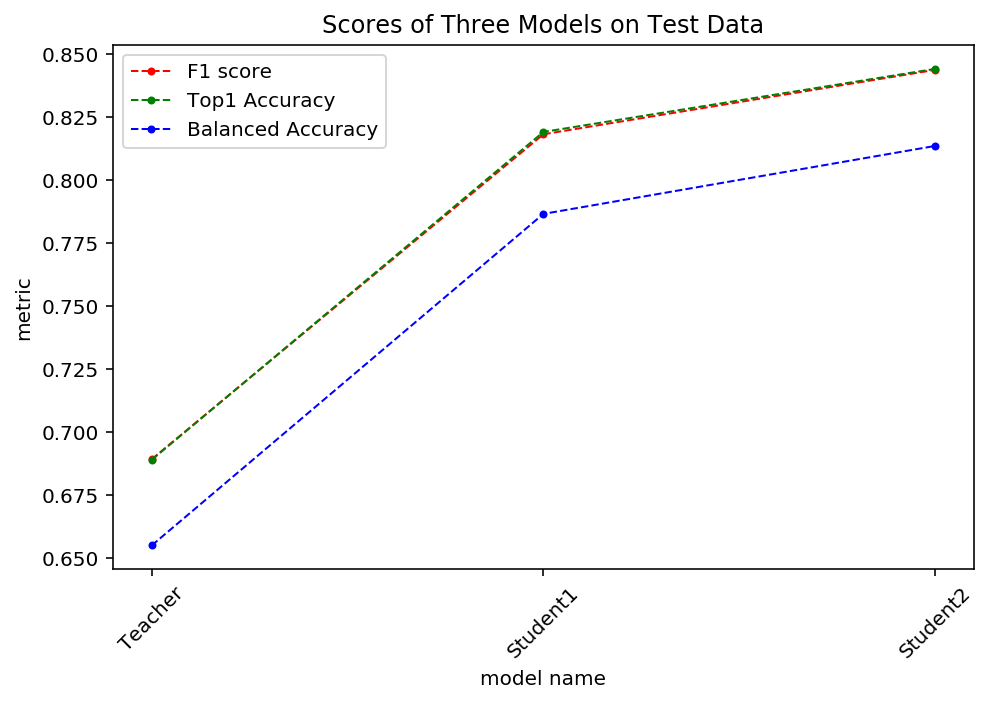

In [61]:
plot_f1_on_test(y_test, y_pred1, y_pred2, y_pred3, save_path=model1_name)

#### Confusion Matrix

In [62]:
# fig, axes = plt.subplots(figsize=(8,4),ncols=2)
def plot_confusion_matrix_3(cm1, cm2, cm3, classes, cmap=plt.cm.Blues, save_path=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    fig, axes = plt.subplots(figsize=(18,6),ncols=3)
    
    # normalized
    cm1 = np.around(cm1,decimals=2)
    cm2 = np.around(cm2,decimals=2)
    cm3 = np.around(cm3,decimals=2)
    
    im_1 = axes[0].imshow(cm1, interpolation='nearest', cmap=cmap)
    axes[0].set_title('Teacher')
    fig.colorbar(im_1,ax=axes[0],shrink=0.75)

    thresh = cm1.max() / 2.
    for i in range(cm1.shape[0]):
        for j in range(cm1.shape[1]):
            axes[0].text(j, i, cm1[i, j],horizontalalignment="center", fontsize=8,
                         color="white" if cm1[i, j] > thresh else "black")
    
    im_2 = axes[1].imshow(cm2, interpolation='nearest', cmap=cmap)
    axes[1].set_title('Student1')
    fig.colorbar(im_2,ax=axes[1],shrink=0.75)

    thresh = cm2.max() / 2.
    for i in range(cm2.shape[0]):
        for j in range(cm2.shape[1]):
            axes[1].text(j, i, cm2[i, j],horizontalalignment="center", fontsize=8,
                         color="white" if cm2[i, j] > thresh else "black")

    im_3 = axes[2].imshow(cm3, interpolation='nearest', cmap=cmap)
    axes[2].set_title('Student2')
    fig.colorbar(im_3,ax=axes[2],shrink=0.75)

    thresh = cm3.max() / 2.
    for i in range(cm3.shape[0]):
        for j in range(cm3.shape[1]):
            axes[2].text(j, i, cm3[i, j],horizontalalignment="center", fontsize=8,
                         color="white" if cm3[i, j] > thresh else "black")
            
    tick_marks = np.arange(len(classes))
    
    for ax in axes:
        ax.set_xticks(tick_marks)
        ax.set_xticklabels(classes, rotation=45)
        ax.set_yticks(tick_marks)
        ax.set_yticklabels(classes, rotation=45)
        ax.set_ylabel('True label')
        ax.set_xlabel('Predicted label')

    plt.tight_layout()
    fig.suptitle('Confusion Matrix for Three Models on Test Data')
    
    if save_path is not None:
        plt.rcParams['savefig.dpi'] = 220
        plt.savefig('./Figures/confusion_matrix_test_'+save_path+'.png')

    plt.show()

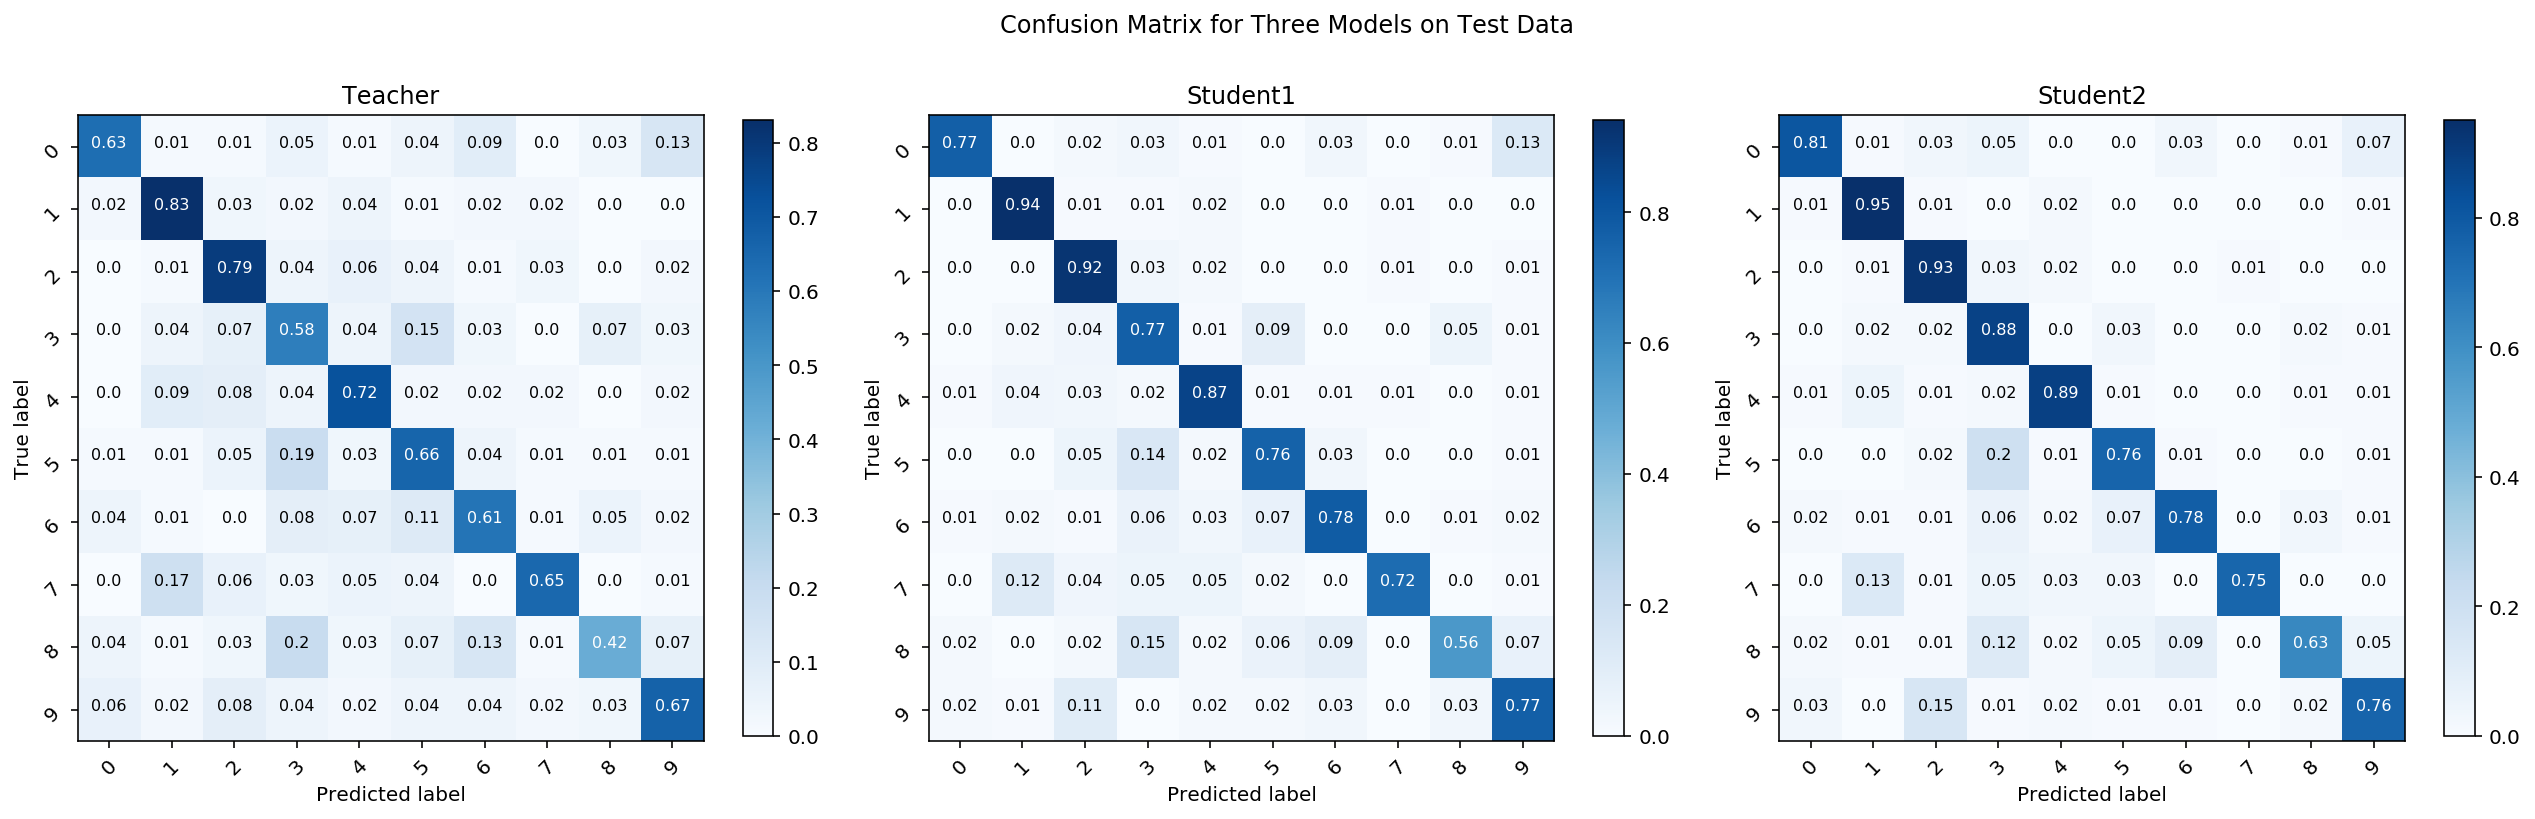

In [63]:
cnf_matrix1 = confusion_matrix(y_test, y_pred1, normalize='true')
cnf_matrix2 = confusion_matrix(y_test, y_pred2, normalize='true')
cnf_matrix3 = confusion_matrix(y_test, y_pred3, normalize='true')
cm_plt = plot_confusion_matrix_3(cnf_matrix1, cnf_matrix2, cnf_matrix3, class_labels, cmap=plt.cm.Blues, save_path=model1_name)

### Save the prediction results to npy file for further comparison

In [ ]:
# np.save('./predictions/x_test.npy', x_test)
# np.save('./predictions/y_test.npy', y_test) # save
# np.save('./predictions/y_teacher_50e.npy', y_pred1) # save
# np.save('./predictions/y_student1_R2_30e.npy', y_pred2) # save
# np.save('./predictions/y_student2_R2_20e.npy', y_pred3) # save